<a href="https://colab.research.google.com/github/djdtimit/Deep-Learning/blob/master/visualizing_what_convnets_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing what convnets learn

convnets are not blackboxes

techniques for visualizing and interpretation:

- Visualizing intermediate convnet outputs (intermediate activations)

- Visualizing convnets filters

- Visualizing heatmaps of class activation in an image

## Visualizing intermediate activations

displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input => visualize these features maps by independently plotting the contents of every channel since every channel encodes relatively independent features

In [0]:
import os
from keras.models import load_model

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
base_dir = '/content/gdrive/My Drive/Colab Notebooks/dogs_vs_cats/cats_and_dogs_small'

In [11]:
model = load_model(os.path.join(base_dir, 'cats_and_dogs_small_h2.h5'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

### Preprocessing a single image

In [0]:
img_path = os.path.join(base_dir, 'test/cats/cat.1700.jpg')

In [0]:
from keras.preprocessing import image # preprocesses the image into a 4D tensor

In [0]:
import numpy as np

In [0]:
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [19]:
print(img_tensor.shape)

(1, 150, 150, 3)


### Displaying the test picture

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

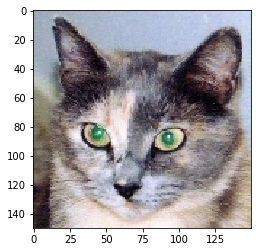

In [23]:
plt.imshow(img_tensor[0])
plt.show()

### Instantiating a model from an input tensor and a list of output tensors

to extract the feature maps, create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers

In [0]:
from keras import models

In [0]:
layer_outputs = [layer.output for layer in model.layers[:8]] # extracts the outputs of the top eight layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # creates a model that will return these outputs, given the model input

When fed an image input, this model returns the values of the layer activations in the original model

### Running the model in predict mode

In [0]:
activations = activation_model.predict(img_tensor) # returns a list of eight numpy arrays: one array per layer activation

In [32]:
len(activations)

8

In [0]:
first_layer_activation = activations[0]

In [35]:
print(first_layer_activation.shape) # 148 x 148 feature map with 32 channels

(1, 148, 148, 32)


### Visualizing the fourth channel

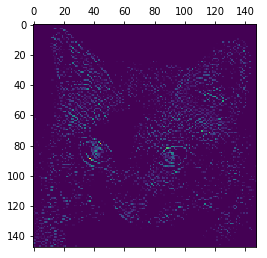

In [36]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

### Visualizing the first channel

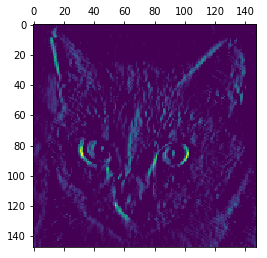

In [50]:
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis') # eye detector

### Visualizing every channel in every intermediate activation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


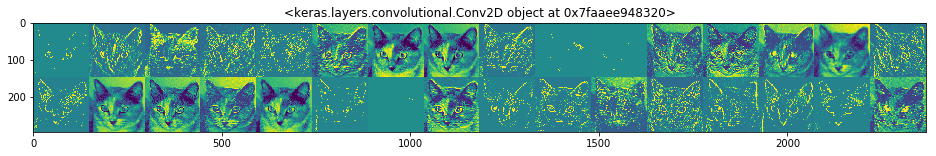

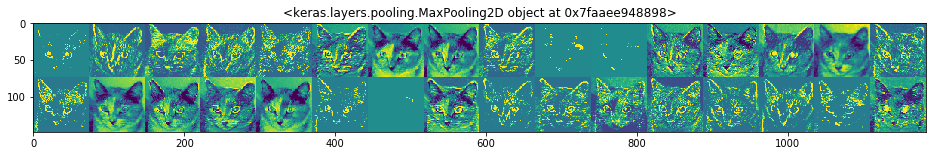

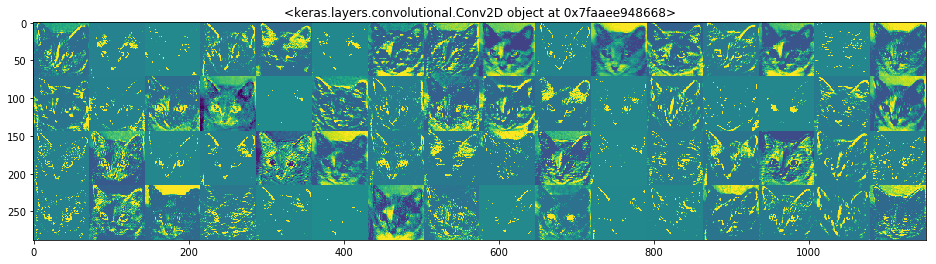

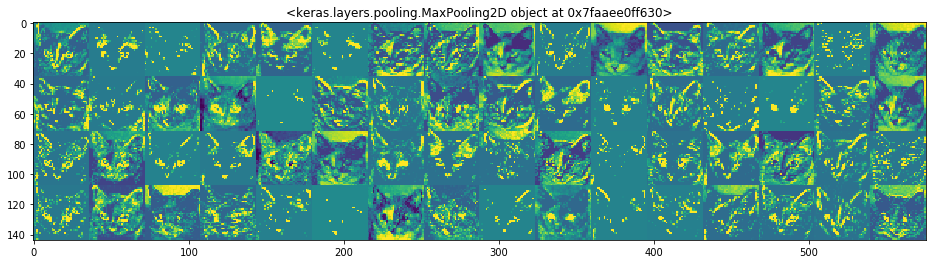

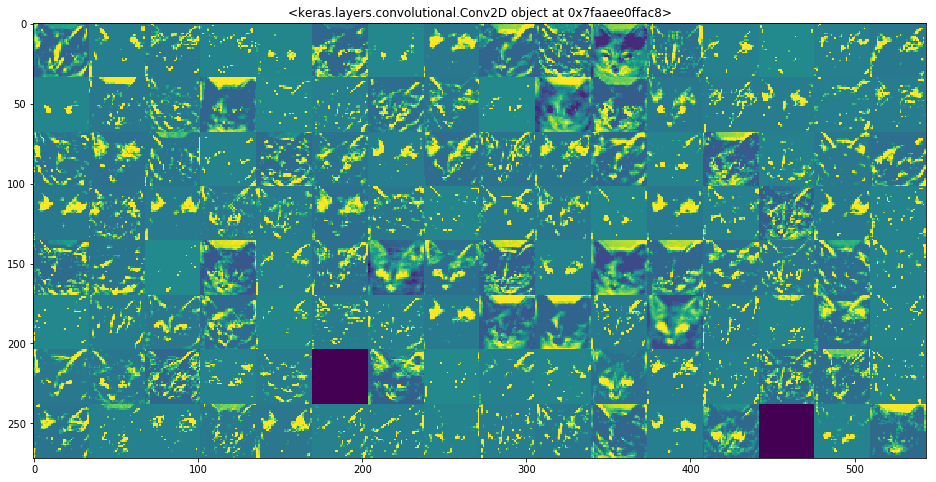

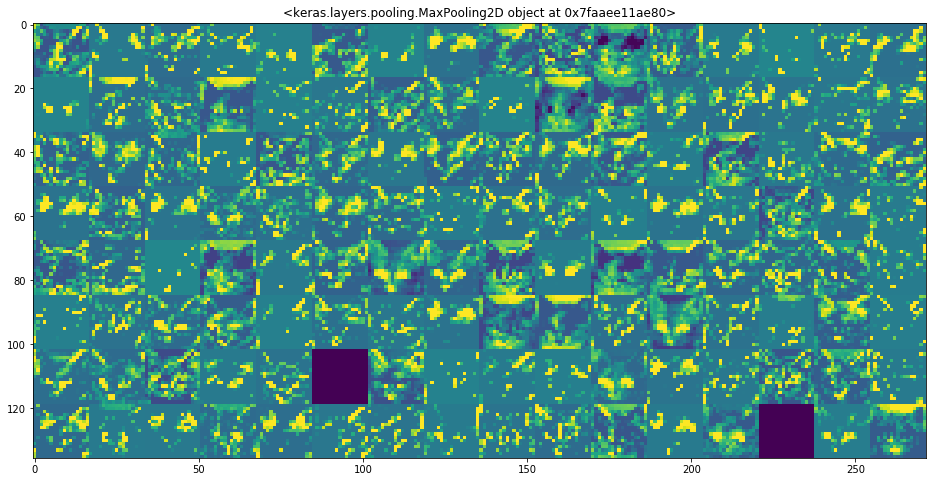

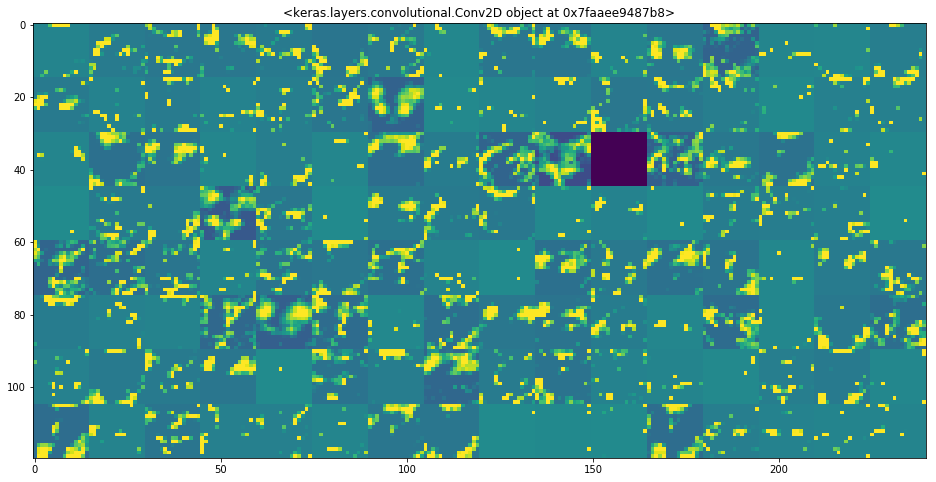

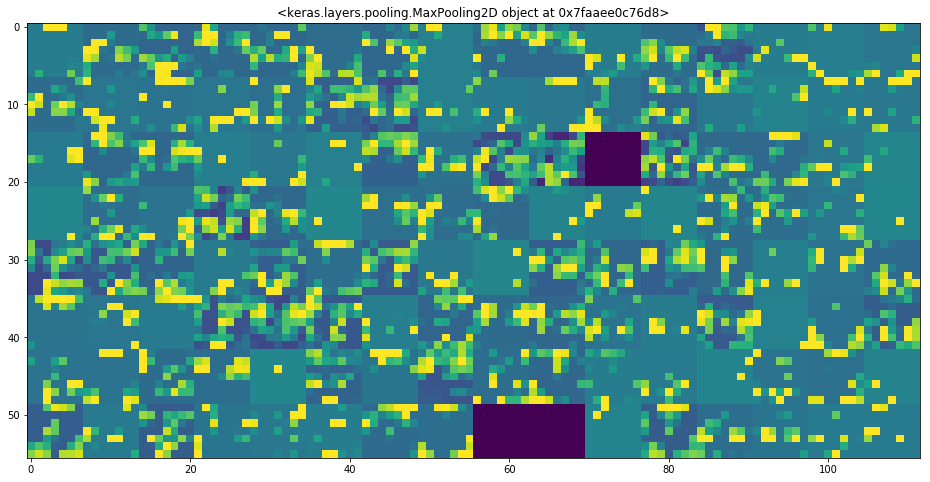

In [53]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1] # number of features in the feature map 

  size = layer_activation.shape[1] # this feature map has shape (i, size, size, n_features)

  n_cols = n_features // images_per_row # tiles the activation channels in this matrix
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row): # tiles each filter into a big horizontal grid
      channel_image = layer_activation[0,:,:,col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
                   row * size : (row + 1) * size] = channel_image # display the grid

  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')